# Process Reddit posts

Reddit threads have been collected with the script `get_subreddit_ids.py` and stored in files named `submissions_ids_ThreadName.txt`. The IDs of the Megathread have been collected manually. Next, subreddit posts have been collected with the script `coronamessagesnl.py` and stored in the directory `downloads`. Threads from different downloads directories have been combined with the script `combineRedditPosts.py`.

In [1]:
import csv
import datetime
import langid
import os
import pandas as pd
import pipes
import re
import sys
import tempfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output
from nltk.tokenize import TweetTokenizer

In [2]:
DATADIRTEXT = "../data/reddit/text/"
DATEFORMATOUT = "%Y%m%d-%H"
SUBREDDIT = "subreddit"
CREATED = "created"
ID = "id"
AUTHOR = "author"
BODY = "body"
PARENT = "parent"
FILESUFFIX = ".out.gz"
IDSTR = "id_str"
REPLYID = "in_reply_to_status_id_str"
USER = "user"
VERIFIED = "verified"
TEXT = "text"
DELETED = "[deleted]"
REMOVED = "[removed]"
NEWLINE = " [NL] "
NL = "nl"
DE = "de"
AF = "af"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [4]:
def makeDateString(date):
    return(datetime.datetime.strftime(datetime.datetime.fromtimestamp(date),DATEFORMATOUT))

In [5]:
def cleanup(text):
    text = re.sub(r"\n",NEWLINE,re.sub(r"\r",NEWLINE,text))
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

## Get all posts from downloaded files (run once per month)

In [ ]:
DATADIRIN = "../data/reddit/"
DOWNLOADS = "downloads"

posts = []
seen = {}
lastMonth = ""
dirs = sorted(os.listdir(DATADIRIN))
for month in dirs:
    if re.search("^2[0-9]{5}$",month):
        lastMonth = month
        dataDirIn = f"{DATADIRIN}{month}/{DOWNLOADS}/"
        files = sorted(os.listdir(dataDirIn))
        for i in range(0,len(files)):
            inFileName = files[i]
            squeal(" ".join([month,str(i),str(len(posts)),inFileName]))
            try:
                df = pd.read_csv(dataDirIn+inFileName)
            except:
                next
            for j in range(0,len(df)):
                date = df.iloc[j][CREATED]
                subReddit = df.iloc[j][SUBREDDIT]
                idStr = subReddit+"_"+df.iloc[j][ID]
                parent = subReddit+"_"+df.iloc[j][PARENT].split("_")[1]
                user = df.iloc[j][AUTHOR]
                text = cleanup(df.iloc[j][BODY])
                if text == DELETED or text == REMOVED: continue
                preprocessedText = preprocess(text)
                language = langid.classify(preprocessedText)[0]
                if language in [NL,AF,DE]:
                    if not idStr in seen:
                        posts.append((makeDateString(date),idStr,parent,user,None,text))
                        seen[idStr] = True
        squeal(" ".join([month,str(i),str(len(posts))]))

## Store all posts in hour files (run once per month)

In [ ]:
verified = ""
dataPerHour = {}
monthCounts = {}
for i in range(0,len(posts)):
    if i%1000 == 0: squeal(i)
    post = posts[i]
    date = post[0]
    idStr = post[1]
    replyId = post[2]
    user = post[3]
    text = cleanup(post[5])
    if not date in dataPerHour: dataPerHour[date] = []
    data = {IDSTR:idStr,REPLYID:replyId,USER:user,VERIFIED:verified,TEXT:text}
    if not data in dataPerHour[date]: 
        dataPerHour[date].append(data)
        month = date[0:6]
        if not month in monthCounts: monthCounts[month] = 0
        monthCounts[month] += 1
squeal(i)

In [ ]:
for month in sorted(monthCounts.keys()):
    print(f"{month}: {monthCounts[month]}")
print(" total:", sum(monthCounts.values())-monthCounts[list(monthCounts.keys())[-1]])

In [ ]:
for date in sorted(dataPerHour.keys()):
    squeal(date)
    outFileName = DATADIRTEXT+date+FILESUFFIX
    pd.DataFrame(dataPerHour[date]).to_csv(outFileName,index=False,compression="gzip")

## Read data

In [7]:
DATE = "date"

def makeDateFromHour(hour):
    return(hour[0:8])

posts = []
for postTime in dataPerHour.keys():
    for post in dataPerHour[postTime]:
        post[DATE] = makeDateFromHour(postTime)
        posts.append(post)

## Visualize number of posts per day

In [6]:
DAYSTART = "-00"

def fileNameToHourString(fileName):
    return(fileName[0:11])

dataPerHour = {}
inFileNames = sorted(os.listdir(DATADIRTEXT))
for inFileName in inFileNames:
    if re.search(DAYSTART,inFileName): squeal(inFileName)
    hourString = fileNameToHourString(inFileName)
    df = pd.read_csv(DATADIRTEXT+inFileName)
    dataPerHour[hourString] = list(df.T.to_dict(orient="dict").values())

20210217-00.out.gz


In [8]:
df = pd.DataFrame(posts)
groups = df.groupby(DATE).groups
dates = {f:len(groups[f]) for f in groups}

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [10]:
lastMonth = "202102"

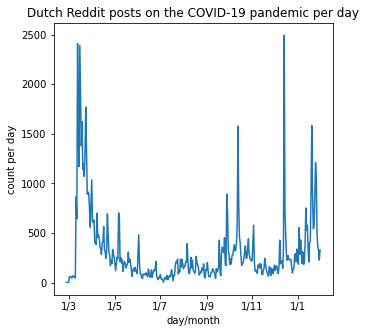

In [11]:
DATEFORMATDAY = "%Y%m%d"
PLOTFILENAME = "frequency-reddit.png"
UNTILDATE = lastMonth+"01"

x = [datetime.datetime.strptime(d,DATEFORMATDAY) for d in dates if d < UNTILDATE]
y = [dates[d] for d in dates if d < UNTILDATE]

fig,ax = plt.subplots(figsize=(5,5))
plt.plot_date(x,y,fmt="-")
plt.xlabel("day/month")
plt.ylabel("count per day")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.title("Dutch Reddit posts on the COVID-19 pandemic per day")
plt.savefig(PLOTFILENAME)
plt.show()

## Visualize query words

In [12]:
TOPIC = "topic"
DISTANCE = "distance"
LOCKDOWN = "lockdown"
WHO = r'\bwho\b'
QUERYLIST = f"corona covid mondkapje rivm blijfthuis houvol huisarts flattenthecurve {TOPIC} {DISTANCE} {LOCKDOWN} pandemic vaccin avondklok {WHO}".split()
TOPICQUERY = "corona|covid|mondkapje|rivm|blijfthuis|houvol|huisarts|flattenthecurve"
PANDEMICQUERY = "|".join([TOPICQUERY, r'virus|besmet|ziekenhui|\bic\b|intensive.care|^zorg|vaccin|[^ad]arts|uitbraak|uitbrak|pandemie|ggd|'+
                                      r'mondkapje|quarantaine|\bwho\b|avondklok|variant|verple|sympto|e.golf|mutant|^omt$|umc|hcq|'+
                                      r'hydroxychloroquine|virolo|zkh|oversterfte|patiënt|patient|intensivist|🦠|ivermectin'])
VACCINQUERY = "vaccin|ingeënt|ingeent|inent|prik|spuit|bijwerking|-->|💉|pfizer|moderna|astrazeneca|astra|zeneca|novavax|biontech"
TESTQUERY = r'\btest|getest|sneltest|pcr'
DISTANCEQUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
LOCKDOWNQUERY = "lock.down|lockdown"
TOTAL = "total"
TEXT = "text"
PANDEMIC = "pandemic"

queryCounts ={}
for query in QUERYLIST:
    squeal(query)
    queryCounts[query] = {}
    if query == TOPIC: querySearch = TOPICQUERY
    elif query == DISTANCE: querySearch = DISTANCEQUERY
    elif query == LOCKDOWN: querySearch = LOCKDOWNQUERY
    elif query == "vaccin": querySearch = VACCINQUERY
    elif query == PANDEMIC: querySearch = "|".join([PANDEMICQUERY, TESTQUERY, VACCINQUERY, LOCKDOWNQUERY, DISTANCEQUERY])
    else: querySearch = query
    for post in posts:
        text = post[TEXT]
        if re.search(querySearch,text,flags=re.IGNORECASE):
            date = makeDateFromHour(post[DATE])
            if not date in queryCounts[query]: queryCounts[query][date] = 0
            queryCounts[query][date] += 1

queryCounts[TOTAL] = {}
for post in posts:
    date = makeDateFromHour(post[DATE])
    if not date in queryCounts[TOTAL]: queryCounts[TOTAL][date] = 0
    queryCounts[TOTAL][date] += 1

totals = {}
for query in QUERYLIST+[TOTAL]:
    totals[query] = sum(queryCounts[query].values())

\bwho\b


In [13]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

In [14]:
WEEKSIZE = 7

queryCounts7 = {}
for query in QUERYLIST+[TOTAL]:
    try:
        sortedKeys = list(sorted(queryCounts[query].keys()))
        sortedValues = [queryCounts[query][d] for d in sortedKeys]
        newSortedValues = movingAverage(sortedValues,WEEKSIZE)
        queryCounts7[query] = {sortedKeys[i]:newSortedValues[i] for i in range(0,len(sortedKeys))}
    except: pass

In [15]:
def prettyPrintNumber(number):
    digits = str(number)
    prettyNumber = ""
    for i in range(-1,-len(digits)-1,-1):
        prettyNumber = digits[i]+prettyNumber
        if i % 3 == 0 and i > -len(digits): prettyNumber = ","+prettyNumber
    return(prettyNumber)

def makeLabel(name,count):
    if name == TOPIC: label = "pandemic"
    elif name == DISTANCE: label = "social distancing"
    elif name == "rivm": label = "RIVM"
    elif name == "vaccin": label = "vaccination"
    elif name == "mondkapje": label = "face masks"
    else: label = name
    return(label+" ("+prettyPrintNumber(count)+")")

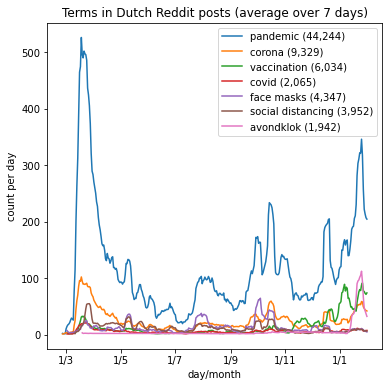

In [16]:
INITDAYSSKIPPED = 0
PLOTFILENAME = "term-frequency-reddit.png"
PLOTTOPICS = [PANDEMIC, "corona", "vaccin", "covid", "mondkapje", DISTANCE, "avondklok"]

fig,ax = plt.subplots(figsize=(6,6))
for query in PLOTTOPICS:
    try:
        x = [datetime.datetime.strptime(d,DATEFORMATDAY) for d in queryCounts7[query] if d < UNTILDATE][INITDAYSSKIPPED:]
        y = [queryCounts7[query][d] for d in queryCounts7[query] if d < UNTILDATE][INITDAYSSKIPPED:]
        plt.plot_date(x,y,fmt="-",label=makeLabel(query,totals[query]))
    except: pass
plt.xlabel("day/month")
plt.ylabel("count per day")
plt.title(f"Terms in Dutch Reddit posts (average over {WEEKSIZE} days)")
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.savefig(PLOTFILENAME)
plt.show()

In [17]:
NBROFCOMBINEDITEMS = 7

def summarizeXY(x,y,nbrOfCombinedItems=NBROFCOMBINEDITEMS):
    summarizedX = []
    summarizedY = []
    yCombined = 0
    for i in range(0,len(y)):
        yCombined += y[i]
        if (i+1)%nbrOfCombinedItems == 0:
            summarizedX.append(x[i])
            summarizedY.append(yCombined)
            yCombined = 0
    if len(y)%nbrOfCombinedItems != 0:
        summarizedX.append(x[i])
        summarizedY.append(yCombined)
    return(summarizedX,summarizedY)

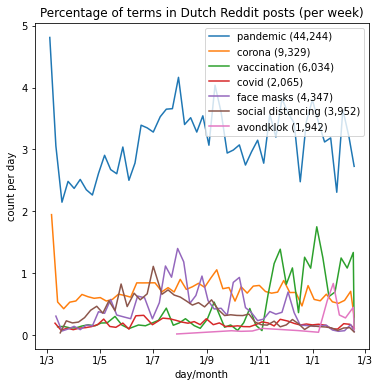

In [18]:
INITDAYSSKIPPED = 0
PLOTFILENAME = "term-percentages-reddit.png"

fig,ax = plt.subplots(figsize=(6,6))
for query in PLOTTOPICS:
    try:
        x = [datetime.datetime.strptime(d,DATEFORMATDAY) for d in queryCounts7[query]][INITDAYSSKIPPED:]
        y = [queryCounts[query][d]/queryCounts[TOTAL][d] for d in queryCounts[query]][INITDAYSSKIPPED:]
        summarizedX,summarizedY = summarizeXY(x,y)
        plt.plot_date(summarizedX,summarizedY,fmt="-",label=makeLabel(query,totals[query]))
    except: pass
plt.xlabel("day/month")
plt.ylabel("count per day")
plt.title(f"Percentage of terms in Dutch Reddit posts (per week)")
plt.legend(loc="upper right")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.savefig(PLOTFILENAME)
plt.show()

## Word clouds

In [75]:
from wordcloud import WordCloud
from collections import Counter

In [92]:
def show_wordcloud(term_frequencies):
    plt.figure(figsize=(30, 30))
    plt.imshow(term_frequencies, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("wordcloud.png")
    plt.show()

In [119]:
stopwords = ("aan aangezien absoluut achter af afgelopen al algemeen alle alleen allemaal allen alles als alsnog alsof altijd ander andere anders "
"antwoord april art augustus basis beeld beetje begin beginnen begint begrijp behalve beide bekend belangrijk ben benieuwd bent bepaalde "
"beperkt best beste betekent beter betreft bezig bij bijna bijv bijvoorbeeld blijf blijft blijkbaar blijkt blijven boven bovendien brengen buiten buurt "
"buurten compleet daadwerkelijk daar daarbij daardoor daarmee daarna daarnaast daarom daarvan daarvoor dacht dag dagen dan dat de december deel denk "
"denken denkt deze dezelfde die dingen direct dit doe doen doet door doordat drie duidelijk dus duurt echt echte echter edit een eens eerder eerlijk eerst "
"eerste eigen eigenlijk eind eindelijk elk elkaar elke en ene enige enkel enkele enorm er erg ergens erger ervan ervoor etc even extra februari fijn flink fout "
"ga gaan gaat gebeuren gebeurt gebruik gebruiken gebruikt gedaan geef geeft geen gegaan gegeven gehad gehouden gek geldt geleden gelijk gelukkig gemaakt genoeg genomen geval "
"geven gevoel gevolgen geweest gewoon geworden gezegd gezien ging gisteren goed goede gooi gooien graag groep groot grootste  grote groter haar had hadden halen half hard heb hebben "
"hebt heeft heel heen helaas hele helemaal helpt hem hen het hetzelfde hier hij hoe hoeft hoeveel hoeveelheid hoeven hoger hoog hoop hoor hopelijk hopen horen hou houd houden "
"houdt huidige hun idee ieder iedere iedereen iemand iets ik in inderdaad ineens informatie ingevoerd inmiddels ipv is ivm ja januari jaren je jezelf jij jonge "
"jou jouw juist juli jullie juni kan kans kant keer kijk kijken klaar klein kleine klinkt klopt kom komen komende komt kon kreeg krijg krijgen krijgt kun kunnen "
"kunt kwam laag laat laatste land landen lang lange langer langs last lastig laten later leer lees lekker letterlijk leven lezen liever liggen ligt lijken lijkt "
"logisch loopt lopen los m'n maak maakt maand maar maart mag maken makkelijk makkelijker man manier me mee meer meerdere meest meeste mei men mensen met "
"meteen middel mij mijn minder misschien mocht moeilijk moest moet moeten mogelijk mogen moment momenteel morgen na naar naast namelijk "
"natuurlijk nauwelijk nauwelijks nederland nederlander nederlanders nederlandse nee neem neemt nemen nergens net niemand niet niets nieuw nieuwe niks nl no "
"nodig nog nogal nooit normaal normale nou november nu of ofzo oktober om omdat on ondanks onder ondertussen ongeveer ons onze ooit ook op openlijk open over overal "
"overigens pa paar pakken pas per persoonlijk plek plekken praten precies prima probeer proberen punt qua raken redelijk relatief rest roepen rond samen september serieus simpelweg "
"sinds slechts snap snel sneller som sommige soms soort sowieso staan staat steed steeds stel stellen sterk strak straks stuk te tegen ten terecht terug "
"terwijl teveel the tijd tijden tijdens to toch toe toen tot totaal trouwens tussen twee u uit uiteindelijk uiteraard uur uw vaak vaker vallen valt van vanaf vandaag vanuit vanwege "
"vast vd veel velen ver verder verhaal verkeerd verplicht verschil verschillende vertrouwen vervolgens verwacht verwachten via vind vinden vindt voelt vol "
"voldoende volgen volgende volgens volledig vond voor vooral voorbij voordat voorkomen vorige vraag vrij vrijdag vrijwel vroeg vs waar waarbij waardoor waarin waarom "
"waarschijnlijk waarvan wachten wanneer want waren was wat we week weer weet weg weinig wel welke wellicht werd werden werken werkt weten wie wij wil willen "
"wilt woord word worden wordt x200b z'n zag zal zat ze zeer zeg zeggen zegt zei zeker zelf zelfs zetten zich zichzelf zie zien ziet zij zijn zin zit zitten zo zo'n "
"zoal zoals zodat zodra zoeken zolang zonder zorgen zorgt zou zouden zoveel zover zowel zullen zwaar één"
)
#print(" ".join(sorted(set(stopwords.lower().split()))))

In [114]:
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white", width=600, height=300, collocations=False, normalize_plurals=False, relative_scaling=1, regexp=r"\w[\w']+",
                      stopwords=(stopwords).split())

In [91]:
text = ""
for post in posts:
    text += " " + post[TEXT]

In [108]:
# uses internal tokenizer
# show_wordcloud(wordcloud.generate(text.lower()))

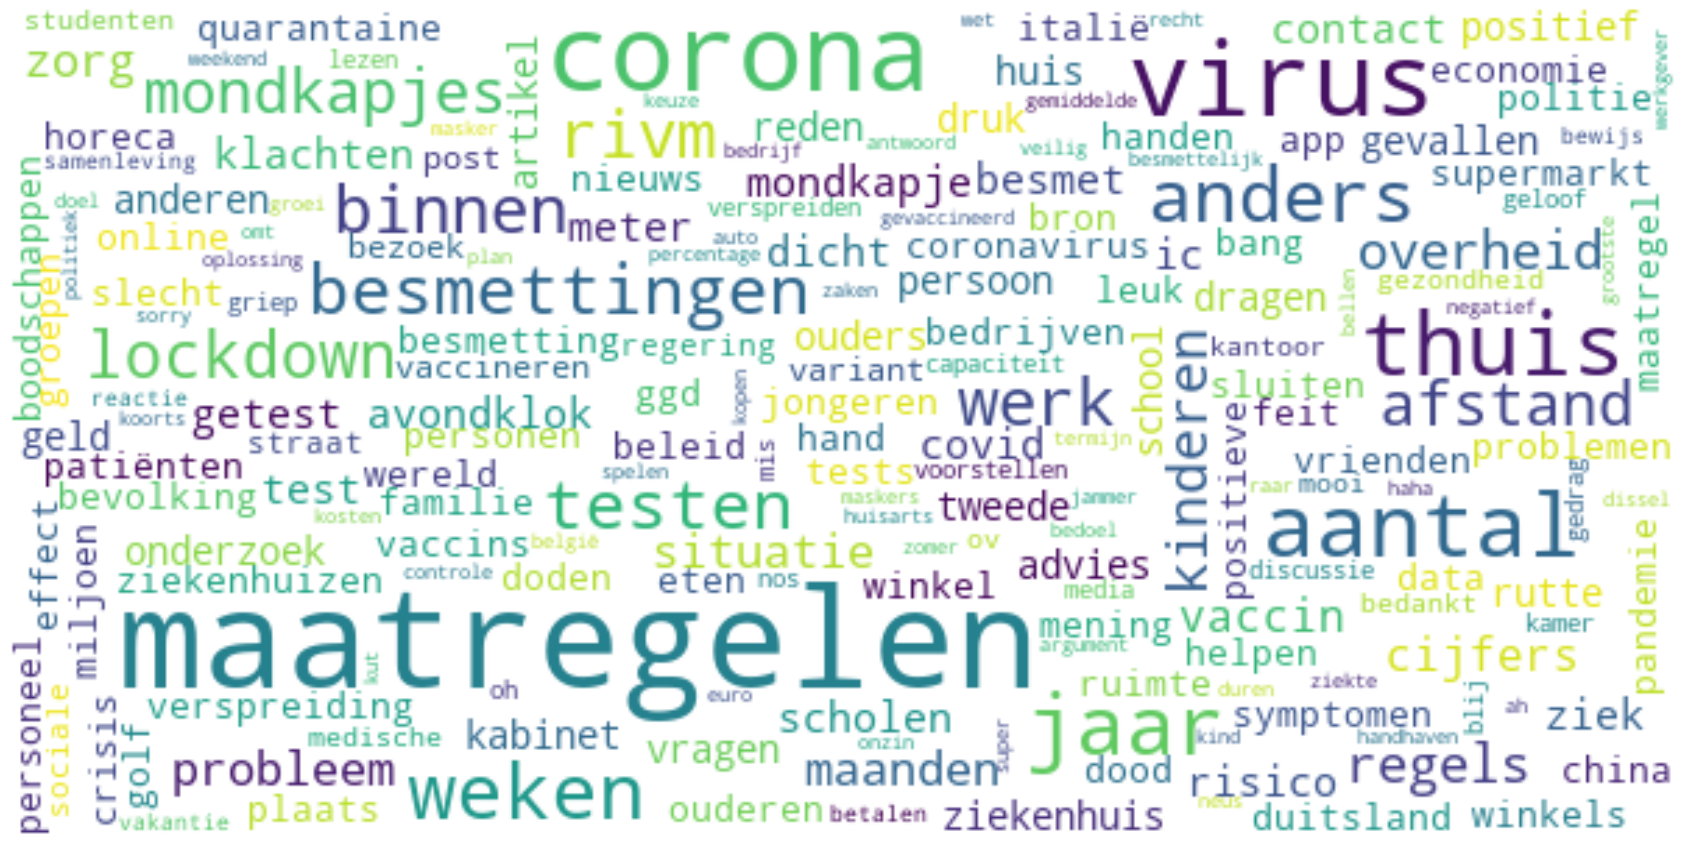

In [118]:
NBR_OF_TOKENS = 200

token_freqs = Counter(tokenize(text.lower()).split())
top = dict([(t,token_freqs[t]) for t in sorted(token_freqs.keys(),key=lambda t:token_freqs[t], reverse=True) if t not in stopwords.split() and re.search("[a-z]", t) and len(t) > 1][:NBR_OF_TOKENS])
show_wordcloud(wordcloud.generate_from_frequencies(top))